<a href="https://colab.research.google.com/github/jdmpjesus/Proyecto-de-Radioenlace/blob/main/Software_Radioenlace_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy matplotlib rasterio pygeomag

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import math
import datetime
import io
from pygeomag import GeoMag

In [ ]:
print("--- Verificando el cálculo de azimut magnético ---")

try:
    # Crear una instancia de GeoMag, especificando la ruta al archivo compatible
    geo_mag = GeoMag(coefficients_file="wmm/WMM_2025.COF")

    # Coordenadas y fecha de ejemplo
    glat = 10.46
    glon = -66.98
    alt = 0.5  # Altitud en km

    today = datetime.date.today()
    year_decimal = today.year + (today.timetuple().tm_yday - 1) / 365.25

    # Realizar el cálculo de la declinación
    result = geo_mag.calculate(glat=glat, glon=glon, alt=alt, time=year_decimal)

    print(f"La declinación magnética en ({glat}, {glon}) es: {result.d:.2f}°")
    print("¡El cálculo de declinación magnética funciona correctamente! 🎉")

except Exception as e:
    print(f"Error: No se pudo realizar el cálculo. Causa: {e}")
    print("Por favor, asegúrate de que el archivo 'WMM_2025.COF' se movió a la carpeta 'wmm'.")

--- Verificando el cálculo de azimut magnético ---
La declinación magnética en (10.46, -66.98) es: -13.17°
¡El cálculo de declinación magnética funciona correctamente! 🎉


In [ ]:
DEM_FILE_PATH = 'dem_venezuela.tif'

def probar_dem(path_dem):
    """
    Función simple para verificar que el archivo DEM se puede abrir y leer.
    """
    print(f"--- Probando el archivo DEM en: {path_dem} ---")
    try:
        with rasterio.open(path_dem) as dem:
            print("¡Éxito! El archivo DEM se abrió correctamente.")
            print(f"Sistema de Coordenadas (CRS): {dem.crs}")
            print(f"Límites del archivo (Bounds): {dem.bounds}")
            print(f"Número de bandas: {dem.count}")
            print(f"Ancho: {dem.width}, Alto: {dem.height}")
        return True
    except Exception as e:
        print(f"ERROR: No se pudo abrir o leer el archivo DEM. Causa: {e}")
        print("Asegúrate de que el nombre del archivo es correcto y que se ha subido al entorno.")
        return False

dem_funciona = probar_dem(DEM_FILE_PATH)

--- Probando el archivo DEM en: dem_venezuela.tif ---
¡Éxito! El archivo DEM se abrió correctamente.
Sistema de Coordenadas (CRS): EPSG:4326
Límites del archivo (Bounds): BoundingBox(left=-73.38625000002422, bottom=0.6145833333468271, right=-59.690416666694, top=12.209583333344192)
Número de bandas: 1
Ancho: 16435, Alto: 13914


In [ ]:
class Radioenlace:
    """
    Clase que encapsula todos los datos y cálculos para un radioenlace.
    Permite una configuración flexible de ganancias de antena, pérdidas fijas
    y parámetros ambientales.
    """
    def __init__(self, lat1, lon1, h_ant1, lat2, lon2, h_ant2, frecuencia, potencia_tx,
                 sensibilidad_rx,
                 ganancia_ant1=None, ganancia_ant2=None, diametro_ant1=None, diametro_ant2=None,
                 eficiencia_ant1=0.65, eficiencia_ant2=0.65,
                 atenuacion_conector_db=0.5, cantidad_conectores=4,
                 atenuacion_cable_o_guia_db_por_metro=0.08, longitud_adicional_cable_o_guia_m=0,
                 factor_k=4/3, temperatura=20, presion=1013.25):

        # --- Entradas Esenciales ---
        self.sitio_a = {'lat': lat1, 'lon': lon1, 'h_ant': h_ant1}
        self.sitio_b = {'lat': lat2, 'lon': lon2, 'h_ant': h_ant2}
        self.frecuencia = frecuencia  # en MHz
        self.potencia_tx = potencia_tx # en dBm
        self.sensibilidad_rx = sensibilidad_rx # en dBm

        # --- Configuración de Ganancia de las Antenas ---
        self._configurar_ganancia(ganancia_ant1, ganancia_ant2, diametro_ant1, diametro_ant2, eficiencia_ant1, eficiencia_ant2)

        # --- Configuración de Pérdidas Fijas ---
        self.perdidas = {}
        self._configurar_perdidas_fijas(atenuacion_conector_db, cantidad_conectores,
                                       atenuacion_cable_o_guia_db_por_metro, longitud_adicional_cable_o_guia_m,
                                       h_ant1, h_ant2)

        # --- Parámetros Ambientales ---
        self.k = factor_k
        self.temperatura = temperatura
        self.presion = presion

        # --- Salidas y Resultados Calculados ---
        self.distancia = 0
        self.azimut_a_b_verdadero = 0
        self.azimut_b_a_verdadero = 0
        self.declinacion_magnetica = 0
        self.azimut_a_b_magnetico = 0
        self.azimut_b_a_magnetico = 0
        self.perfil_topografico = []
        self.linea_de_vista_ok = False
        self.despeje_minimo_fresnel = 0
        self.presupuesto = {}
        self.angulo_elevacion_a_b = 0
        self.angulo_elevacion_b_a = 0

    def _configurar_ganancia(self, ganancia_ant1, ganancia_ant2, diametro_ant1, diametro_ant2, eficiencia_ant1, eficiencia_ant2):
        f_ghz = self.frecuencia / 1000
        longitud_onda = 0.3 / f_ghz

        if ganancia_ant1 is not None:
            self.ganancia_ant_tx = ganancia_ant1
        elif diametro_ant1 is not None:
            ganancia_lineal_tx = eficiencia_ant1 * ((math.pi * diametro_ant1) / longitud_onda)**2
            self.ganancia_ant_tx = 10 * math.log10(ganancia_lineal_tx)
            print(f"Ganancia de antena TX calculada (D={diametro_ant1}m, F={self.frecuencia}MHz, Efic.={eficiencia_ant1}): {self.ganancia_ant_tx:.2f} dBi")
        else:
            raise ValueError("Debe proporcionar ganancia_ant1 o diametro_ant1.")

        if ganancia_ant2 is not None:
            self.ganancia_ant_rx = ganancia_ant2
        elif diametro_ant2 is not None:
            ganancia_lineal_rx = eficiencia_ant2 * ((math.pi * diametro_ant2) / longitud_onda)**2
            self.ganancia_ant_rx = 10 * math.log10(ganancia_lineal_rx)
            print(f"Ganancia de antena RX calculada (D={diametro_ant2}m, F={self.frecuencia}MHz, Efic.={eficiencia_ant2}): {self.ganancia_ant_rx:.2f} dBi")
        else:
            raise ValueError("Debe proporcionar ganancia_ant2 o diametro_ant2.")

    def _configurar_perdidas_fijas(self, atenuacion_conector_db, cantidad_conectores,
                                   atenuacion_cable_o_guia_db_por_metro, longitud_adicional_cable_o_guia_m,
                                   h_ant1, h_ant2):
        self.perdidas['Fijas'] = {}
        perdida_conectores = atenuacion_conector_db * cantidad_conectores
        self.perdidas['Fijas']['Conectores'] = perdida_conectores
        print(f"Pérdidas por {cantidad_conectores} conectores: {perdida_conectores:.2f} dB")

        longitud_total_cable = h_ant1 + h_ant2 + longitud_adicional_cable_o_guia_m
        perdida_cable = longitud_total_cable * atenuacion_cable_o_guia_db_por_metro
        self.perdidas['Fijas']['Cables/Guía de Onda'] = perdida_cable
        print(f"Pérdidas por cable/guía de onda ({longitud_total_cable:.1f}m): {perdida_cable:.2f} dB")

        self.perdidas_fijas_total = perdida_conectores + perdida_cable
        self.perdidas['Fijas']['Total Calculado'] = self.perdidas_fijas_total
        print(f"Pérdidas fijas totales calculadas: {self.perdidas_fijas_total:.2f} dB")

    def calcular_distancia_azimut(self):
        """Calcula distancia, azimut verdadero y azimut magnético."""
        lat1_rad, lon1_rad = np.radians(self.sitio_a['lat']), np.radians(self.sitio_a['lon'])
        lat2_rad, lon2_rad = np.radians(self.sitio_b['lat']), np.radians(self.sitio_b['lon'])

        dlon = lon2_rad - lon1_rad
        dlat = lat2_rad - lat1_rad

        a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        R_TIERRA = 6371
        self.distancia = R_TIERRA * c

        y = np.sin(dlon) * np.cos(lat2_rad)
        x = np.cos(lat1_rad) * np.sin(lat2_rad) - np.sin(lat1_rad) * np.cos(lat2_rad) * np.cos(dlon)
        self.azimut_a_b_verdadero = (np.degrees(np.arctan2(y, x)) + 360) % 360
        self.azimut_b_a_verdadero = (self.azimut_a_b_verdadero + 180) % 360

        print(f"Distancia: {self.distancia:.2f} km")
        print(f"Azimut Verdadero A->B: {self.azimut_a_b_verdadero:.2f}°")

        try:
            fecha_actual = datetime.date.today()
            year_decimal = fecha_actual.year + (fecha_actual.timetuple().tm_yday - 1) / 365.25

            # Asegurarse de que el perfil topográfico se ha cargado para obtener la altitud
            altitud_a_m = self.perfil_topografico[0][1] if self.perfil_topografico else 0

            # Crea una instancia de GeoMag. No se requiere un archivo de coeficientes
            # si la librería ya lo incluye.
            gm = GeoMag()

            # Llama al método 'calculate' con los argumentos correctos
            result = gm.calculate(
                glat=self.sitio_a['lat'],
                glon=self.sitio_a['lon'],
                alt=altitud_a_m / 1000, # Se espera en km
                time=year_decimal
            )

            self.declinacion_magnetica = result.d
            self.azimut_a_b_magnetico = self.azimut_a_b_verdadero - self.declinacion_magnetica
            self.azimut_b_a_magnetico = self.azimut_b_a_verdadero - self.declinacion_magnetica

            print(f"Declinación Magnética en Sitio A: {self.declinacion_magnetica:.2f}°")
            print(f"Azimut Magnético A->B: {self.azimut_a_b_magnetico:.2f}°")
            print(f"Azimut Magnético B->A: {self.azimut_b_a_magnetico:.2f}°")

        except Exception as e:
            print(f"ADVERTENCIA: No se pudo calcular el azimut magnético. Causa: {e}")
            self.declinacion_magnetica = 0
            self.azimut_a_b_magnetico = self.azimut_a_b_verdadero
            self.azimut_b_a_magnetico = self.azimut_b_a_verdadero

    def obtener_perfil_topografico(self, dem_path, num_puntos=200):
        """Extrae el perfil de elevación desde el archivo DEM."""
        lons = np.linspace(self.sitio_a['lon'], self.sitio_b['lon'], num_puntos)
        lats = np.linspace(self.sitio_a['lat'], self.sitio_b['lat'], num_puntos)
        try:
            with rasterio.open(dem_path) as dem:
                puntos_coord = list(zip(lons, lats))
                altitudes = [alt[0] for alt in dem.sample(puntos_coord)]
            distancias_perfil = np.linspace(0, self.distancia, num_puntos)
            self.perfil_topografico = list(zip(distancias_perfil, altitudes))
            print("Perfil topográfico extraído.")
        except Exception as e:
            print(f"ERROR al extraer el perfil topográfico: {e}")
            self.perfil_topografico = []

    def _calcular_angulos_elevacion(self):
        """Calcula los ángulos de elevación de las antenas, considerando la curvatura terrestre."""
        if not self.perfil_topografico or self.distancia == 0:
            print("No se pueden calcular los ángulos de elevación: perfil o distancia no disponibles.")
            return

        alt_antena_a_m = self.perfil_topografico[0][1] + self.sitio_a['h_ant']
        alt_antena_b_m = self.perfil_topografico[-1][1] + self.sitio_b['h_ant']
        distancia_m = self.distancia * 1000
        R_efectiva_m = 6371000 * self.k

        # Ángulo de A a B
        termino_dif_altura_ab = (alt_antena_b_m - alt_antena_a_m) / distancia_m
        termino_curvatura = distancia_m / (2 * R_efectiva_m)
        self.angulo_elevacion_a_b = np.degrees(math.atan(termino_dif_altura_ab - termino_curvatura))
        print(f"Ángulo de Elevación de A a B: {self.angulo_elevacion_a_b:.2f}°")

        # Ángulo de B a A
        termino_dif_altura_ba = (alt_antena_a_m - alt_antena_b_m) / distancia_m
        self.angulo_elevacion_b_a = np.degrees(math.atan(termino_dif_altura_ba - termino_curvatura))
        print(f"Ángulo de Elevación de B a A: {self.angulo_elevacion_b_a:.2f}°")

    def _calcular_perdidas_nubes_niebla(self, densidad_agua=0.25):
        """Calcula la atenuación por nubes y niebla (modelo simplificado)."""
        f_ghz = self.frecuencia / 1000
        if f_ghz < 10:
            self.perdidas['Nubes y Niebla'] = 0
            return 0

        # Coeficiente de atenuación K_L para una temperatura de 15°C
        k_l = 0.001 + 0.1 * (f_ghz - 10)**2
        perdida = k_l * densidad_agua * self.distancia

        self.perdidas['Nubes y Niebla'] = perdida
        return perdida

    def _calcular_perdidas_vegetacion(self, profundidad_vegetacion_m=10):
        """Calcula la atenuación por vegetación (modelo simplificado)."""
        f_ghz = self.frecuencia / 1000
        if profundidad_vegetacion_m == 0:
            self.perdidas['Vegetación'] = 0
            return 0

        # Coeficiente simplificado para follaje denso
        c_f = 0.39
        perdida = c_f * f_ghz**0.28 * (profundidad_vegetacion_m / 10)

        self.perdidas['Vegetación'] = perdida
        return perdida

    def verificar_linea_de_vista_y_despeje(self):
      """Verifica la línea de vista y calcula el despeje y la pérdida por difracción."""
      if not self.perfil_topografico:
          print("No se pudo verificar la línea de vista: perfil no disponible.")
          self.linea_de_vista_ok = False
          self.despeje_minimo_fresnel = 0
          self.perdidas['Difracción'] = 0
          return

      alt_antena_a = self.perfil_topografico[0][1] + self.sitio_a['h_ant']
      alt_antena_b = self.perfil_topografico[-1][1] + self.sitio_b['h_ant']
      self.linea_de_vista_ok = True
      despejes_relativos = []
      factor_v_max = 0 # Para el peor punto de obstrucción. Se inicia en 0.

      for d_km, alt_terreno in self.perfil_topografico:
          if d_km == 0 or d_km == self.distancia: continue

          R_efectiva_km = 6371 * self.k

          # Altura de la LOS corregida por curvatura terrestre
          h_los_recta = alt_antena_a + (alt_antena_b - alt_antena_a) * (d_km / self.distancia)
          correccion_curvatura = (d_km * (self.distancia - d_km) * 1000) / (2 * R_efectiva_km)
          h_los_curva = h_los_recta - correccion_curvatura

          f_ghz = self.frecuencia / 1000
          radio_fresnel = 17.32 * np.sqrt((d_km * (self.distancia - d_km)) / (f_ghz * self.distancia))

          clearance = h_los_curva - alt_terreno

          if radio_fresnel > 0:
              despejes_relativos.append(clearance / radio_fresnel)

          if clearance < 0.6 * radio_fresnel:
              self.linea_de_vista_ok = False

          # --- Cálculo del factor de difracción 'v' ---
          h = alt_terreno - h_los_curva # Altura del obstáculo sobre la LOS

          if h > 0:
              longitud_onda_m = 3e8 / (self.frecuencia * 1e6)
              d1_m = d_km * 1000
              d2_m = (self.distancia - d_km) * 1000

              if d1_m > 0 and d2_m > 0:
                  v = h / (math.sqrt(longitud_onda_m * d1_m * d2_m / (d1_m + d2_m)))
                  factor_v_max = max(factor_v_max, v)

      # El despeje mínimo es el punto más bajo en relación a la zona de Fresnel.
      self.despeje_minimo_fresnel = min(despejes_relativos) * 100 if despejes_relativos else 100

      # --- Lógica de impresión corregida ---
      if self.despeje_minimo_fresnel < 0:
          print(f"Verificación de LOS: OBSTRUIDO (obstrucción significativa)")
          print(f"Despeje de la 1ra Zona de Fresnel: 0.0%")
      elif self.despeje_minimo_fresnel < 60:
          print(f"Verificación de LOS: Obstrucción Parcial")
          print(f"Despeje de la 1ra Zona de Fresnel: {self.despeje_minimo_fresnel:.1f}%")
      else:
          print(f"Verificación de LOS: OK")
          print(f"Despeje de la 1ra Zona de Fresnel: {self.despeje_minimo_fresnel:.1f}%")

      # --- Cálculo de la pérdida de difracción ---
      if factor_v_max > 0:
          perdida_difraccion_db = 6.9 + 20 * np.log10(np.sqrt(factor_v_max**2 + 1) + factor_v_max)
      else:
          perdida_difraccion_db = 0

      self.perdidas['Difracción'] = perdida_difraccion_db
      print(f"Pérdida por Difracción calculada: {perdida_difraccion_db:.2f} dB")

    def _calcular_perdidas_espacio_libre(self):
        """Calcula las pérdidas por espacio libre (FSPL)."""
        pel = 20 * np.log10(self.distancia) + 20 * np.log10(self.frecuencia) + 32.45
        self.perdidas['Espacio Libre'] = pel
        return pel

    def _calcular_perdidas_gases(self, calc_gases=True):
        """Calcula las pérdidas por gases atmosféricos (modelo simplificado)."""
        if not calc_gases:
            self.perdidas['Gases Atmosféricos'] = 0
            return 0
        f_ghz = self.frecuencia / 1000
        gamma_o = 0.01
        if 50 <= f_ghz <= 70: gamma_o = 15
        gamma_w = 0.005
        if 20 <= f_ghz <= 24: gamma_w = 0.2
        perdida_gases = (gamma_o + gamma_w) * self.distancia
        self.perdidas['Gases Atmosféricos'] = perdida_gases
        return perdida_gases

    def ejecutar_analisis_completo(self, **kwargs):
        """Ejecuta todos los pasos del análisis en orden."""
        print("\n--- INICIANDO ANÁLISIS COMPLETO DEL RADIOENLACE ---")

        # 1. Cálculos geométricos básicos
        self.calcular_distancia_azimut()

        # 2. Perfil y cálculos dependientes del perfil
        dem_file_path = kwargs.get('dem_path', None)
        if dem_file_path:
            self.obtener_perfil_topografico(dem_path=dem_file_path)
            self._calcular_angulos_elevacion()
            self.verificar_linea_de_vista_y_despeje()
        else:
            print("ADVERTENCIA: No se proporcionó un archivo DEM. Omitiendo análisis de LOS y difracción.")
            self.linea_de_vista_ok = False
            self.despeje_minimo_fresnel = 0
            self.perdidas['Difracción'] = 0

        # 3. Recalcular azimut para incluir el magnético ahora que tenemos la altitud del perfil
        if self.perfil_topografico:
            print("\n--- Recalculando Azimut con Altitud Precisa ---")
            self.calcular_distancia_azimut()

        # 4. Cálculo de pérdidas
        perdidas_fijas_guardadas = self.perdidas.get('Fijas', {})
        self.perdidas = {'Fijas': perdidas_fijas_guardadas}
        total_perdidas_dinamicas = 0
        total_perdidas_dinamicas += self._calcular_perdidas_espacio_libre()
        total_perdidas_dinamicas += self._calcular_perdidas_gases(calc_gases=kwargs.get('calc_gases', True))

        total_perdidas_dinamicas += self._calcular_perdidas_nubes_niebla(densidad_agua=kwargs.get('densidad_agua', 0.25))
        total_perdidas_dinamicas += self._calcular_perdidas_vegetacion(profundidad_vegetacion_m=kwargs.get('profundidad_vegetacion_m', 10))

        total_perdidas_dinamicas += self.perdidas.get('Difracción', 0)

        self.perdidas['TOTALES'] = total_perdidas_dinamicas + self.perdidas_fijas_total

        # 5. Presupuesto de potencia
        pire = self.potencia_tx + self.ganancia_ant_tx - self.perdidas_fijas_total
        nivel_recepcion = pire - total_perdidas_dinamicas + self.ganancia_ant_rx
        margen = nivel_recepcion - self.sensibilidad_rx

        self.presupuesto['PIRE (dBm)'] = pire
        self.presupuesto['Nivel de Recepción (dBm)'] = nivel_recepcion
        self.presupuesto['Margen de Desvanecimiento (dB)'] = margen

        print("--- ANÁLISIS FINALIZADO ---")



=== EJECUTANDO SIMULACIÓN DE UN ENLACE ===
Ganancia de antena RX calculada (D=0.6m, F=5800MHz, Efic.=0.7): 29.68 dBi
Pérdidas por 4 conectores: 2.80 dB
Pérdidas por cable/guía de onda (110.0m): 8.80 dB
Pérdidas fijas totales calculadas: 11.60 dB

--- INICIANDO ANÁLISIS COMPLETO DEL RADIOENLACE ---
Distancia: 115.10 km
Azimut Verdadero A->B: 253.82°
Declinación Magnética en Sitio A: -13.17°
Azimut Magnético A->B: 266.99°
Azimut Magnético B->A: 86.99°
Perfil topográfico extraído.
Ángulo de Elevación de A a B: -0.67°
Ángulo de Elevación de B a A: -0.11°
Verificación de LOS: OBSTRUIDO (obstrucción significativa)
Despeje de la 1ra Zona de Fresnel: 0.0%
Pérdida por Difracción calculada: 45.17 dB

--- Recalculando Azimut con Altitud Precisa ---
Distancia: 115.10 km
Azimut Verdadero A->B: 253.82°
Declinación Magnética en Sitio A: -13.17°
Azimut Magnético A->B: 266.99°
Azimut Magnético B->A: 86.99°
--- ANÁLISIS FINALIZADO ---

--- RESULTADOS DEL ENLACE ---

[Orientación de Antenas]
  Distanci

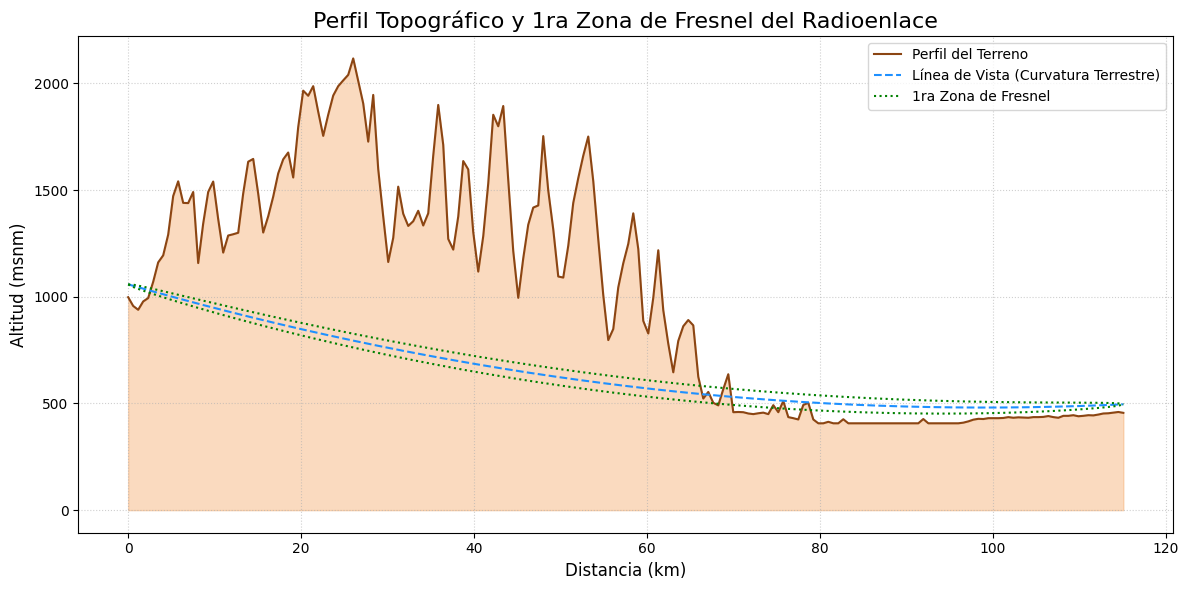

In [ ]:
# --- Bloque de Ejecución Principal ---
if 'dem_funciona' in globals() and dem_funciona:
    print("\n\n=== EJECUTANDO SIMULACIÓN DE UN ENLACE ===")
    enlace_prueba = Radioenlace(
        lat1=10.46, lon1=-66.98, h_ant1=60,      # Sitio A: El Ávila
        lat2=10.17, lon2=-67.99, h_ant2=40,      # Sitio B: Cerro El Café
        frecuencia=5800,
        potencia_tx=20,
        ganancia_ant1=23,
        diametro_ant2=0.6, eficiencia_ant2=0.7,
        sensibilidad_rx=-90,
        atenuacion_conector_db=0.7,
        cantidad_conectores=4,
        atenuacion_cable_o_guia_db_por_metro=0.08,
        longitud_adicional_cable_o_guia_m=10,
        factor_k=4/3
    )

    enlace_prueba.ejecutar_analisis_completo(dem_path=DEM_FILE_PATH, calc_gases=True)

    # --- MOSTRAR RESULTADOS ---
    print("\n--- RESULTADOS DEL ENLACE ---")
    print("\n[Orientación de Antenas]")
    print(f"  Distancia: {enlace_prueba.distancia:.2f} km")
    print(f"  Azimut Verdadero (A->B): {enlace_prueba.azimut_a_b_verdadero:.2f}°")
    print(f"  Azimut Magnético (A->B): {enlace_prueba.azimut_a_b_magnetico:.2f}° (Declinación: {enlace_prueba.declinacion_magnetica:.2f}°)")
    print(f"  Ángulo Elevación (A->B): {enlace_prueba.angulo_elevacion_a_b:.2f}°")

    print("\n[Presupuesto de Potencia]")
    for key, value in enlace_prueba.presupuesto.items():
        print(f"  {key}: {value:.2f}")

    print("\n[Desglose de Pérdidas (dB)]")
    for key, value in enlace_prueba.perdidas.items():
        if isinstance(value, dict):
            print(f"  {key}:")
            for sub_key, sub_value in value.items():
                print(f"    {sub_key}: {sub_value:.2f}")
        else:
            print(f"  {key}: {value:.2f}")

    # --- GENERAR GRÁFICO DEL PERFIL ---
    if enlace_prueba.perfil_topografico:
        dist = np.array([p[0] for p in enlace_prueba.perfil_topografico])
        alt = np.array([p[1] for p in enlace_prueba.perfil_topografico])
        alt_ant_a = alt[0] + enlace_prueba.sitio_a['h_ant']
        alt_ant_b = alt[-1] + enlace_prueba.sitio_b['h_ant']

        # Cálculo de la 1ra Zona de Fresnel
        f_ghz = enlace_prueba.frecuencia / 1000
        longitud_onda_m = 3e8 / (enlace_prueba.frecuencia * 1e6)
        dist_total_m = enlace_prueba.distancia * 1000

        # Se calcula el radio de la primera zona de Fresnel en cada punto
        # Se usa una máscara para evitar la división por cero en los extremos
        mask = (dist > 0) & (dist < enlace_prueba.distancia)

        radios_fresnel = np.zeros_like(dist)
        radios_fresnel[mask] = np.sqrt((dist[mask] * (enlace_prueba.distancia - dist[mask])) / (f_ghz * enlace_prueba.distancia)) * 17.32

        # Se calcula la altura de la línea de vista corregida por la curvatura terrestre
        dist_m = dist * 1000
        h_los_recta = alt_ant_a + (alt_ant_b - alt_ant_a) * (dist_m / dist_total_m)
        correccion_curvatura = (dist_m * (dist_total_m - dist_m)) / (2 * 6371000 * enlace_prueba.k)
        h_los_curva = h_los_recta - correccion_curvatura

        # Se definen las envolventes superior e inferior de la Zona de Fresnel
        elipsoide_sup = h_los_curva + radios_fresnel
        elipsoide_inf = h_los_curva - radios_fresnel

        # Gráfico
        plt.figure(figsize=(12, 6))
        plt.plot(dist, alt, color='saddlebrown', label='Perfil del Terreno')
        plt.fill_between(dist, alt, color='sandybrown', alpha=0.4)

        # Se traza la línea de vista corregida
        plt.plot(dist, h_los_curva, color='dodgerblue', linestyle='--', label='Línea de Vista (Curvatura Terrestre)')

        # Se traza la primera zona de Fresnel
        plt.plot(dist, elipsoide_sup, color='green', linestyle=':', label='1ra Zona de Fresnel')
        plt.plot(dist, elipsoide_inf, color='green', linestyle=':')

        plt.title('Perfil Topográfico y 1ra Zona de Fresnel del Radioenlace', fontsize=16)
        plt.xlabel('Distancia (km)', fontsize=12)
        plt.ylabel('Altitud (msnm)', fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("\nNo se pudo ejecutar la simulación porque el DEM no está funcionando correctamente.")


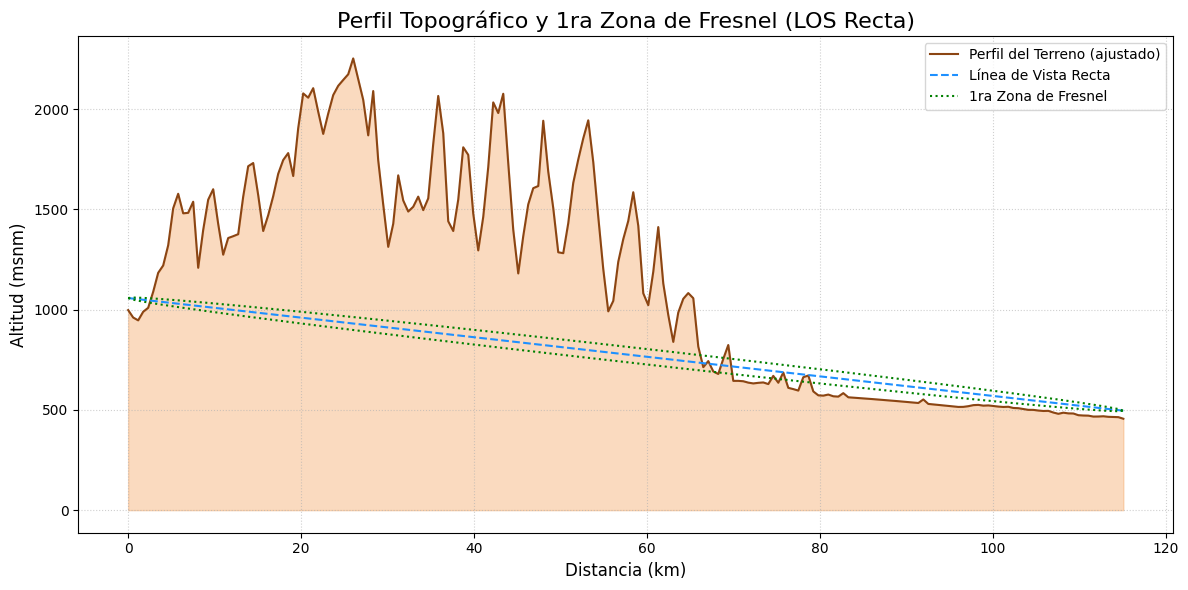

In [ ]:
# --- GENERAR GRÁFICO DEL PERFIL ---
if enlace_prueba.perfil_topografico:
    dist = np.array([p[0] for p in enlace_prueba.perfil_topografico])
    alt_terreno_original = np.array([p[1] for p in enlace_prueba.perfil_topografico])

    # Alturas de las antenas sobre el nivel del mar
    alt_ant_a = alt_terreno_original[0] + enlace_prueba.sitio_a['h_ant']
    alt_ant_b = alt_terreno_original[-1] + enlace_prueba.sitio_b['h_ant']

    # Se calculan las alturas del terreno ajustadas por la curvatura terrestre
    dist_m = dist * 1000
    dist_total_m = enlace_prueba.distancia * 1000
    R_efectiva_m = 6371000 * enlace_prueba.k

    correccion_curvatura = (dist_m * (dist_total_m - dist_m)) / (2 * R_efectiva_m)
    alt_terreno_ajustada = alt_terreno_original + correccion_curvatura

    # Se calcula la 1ra Zona de Fresnel
    f_ghz = enlace_prueba.frecuencia / 1000
    radios_fresnel = np.sqrt((dist * (enlace_prueba.distancia - dist)) / (f_ghz * enlace_prueba.distancia)) * 17.32

    # Se define la línea de vista como una recta simple
    h_los_recta = alt_ant_a + (alt_ant_b - alt_ant_a) * (dist / enlace_prueba.distancia)

    # Se definen las envolventes superior e inferior de la Zona de Fresnel
    elipsoide_sup = h_los_recta + radios_fresnel
    elipsoide_inf = h_los_recta - radios_fresnel

    # Gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(dist, alt_terreno_ajustada, color='saddlebrown', label='Perfil del Terreno (ajustado)')
    plt.fill_between(dist, alt_terreno_ajustada, color='sandybrown', alpha=0.4)

    # Se traza la línea de vista como una recta
    plt.plot(dist, h_los_recta, color='dodgerblue', linestyle='--', label='Línea de Vista Recta')

    # Se traza la primera zona de Fresnel como un elipsoide
    plt.plot(dist, elipsoide_sup, color='green', linestyle=':', label='1ra Zona de Fresnel')
    plt.plot(dist, elipsoide_inf, color='green', linestyle=':')

    plt.title('Perfil Topográfico y 1ra Zona de Fresnel (LOS Recta)', fontsize=16)
    plt.xlabel('Distancia (km)', fontsize=12)
    plt.ylabel('Altitud (msnm)', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
print("\n--- Validación de Radios de la 1ra Zona de Fresnel ---")
print(f"Distancia Total del Enlace: {enlace_prueba.distancia:.2f} km")
print(f"Frecuencia: {enlace_prueba.frecuencia} MHz")
print("-" * 50)
print(f"{'Distancia (km)':<15} | {'Radio Fresnel (m)':<20}")
print("-" * 50)

# Puntos a lo largo del enlace para la validación
puntos_de_prueba = np.arange(10, enlace_prueba.distancia, 10)
# Agregamos el punto medio exacto
punto_medio = enlace_prueba.distancia / 2
if punto_medio not in puntos_de_prueba:
    puntos_de_prueba = np.append(puntos_de_prueba, punto_medio)
puntos_de_prueba.sort()

f_ghz = enlace_prueba.frecuencia / 1000

for d_km in puntos_de_prueba:
    # d1 es la distancia desde el inicio
    d1 = d_km
    # d2 es la distancia restante
    d2 = enlace_prueba.distancia - d1

    # Se calcula el radio de la 1ra Zona de Fresnel con la fórmula correcta
    if d1 == 0 or d2 == 0:
        radio_fresnel = 0
    else:
        radio_fresnel = 17.32 * np.sqrt((d1 * d2) / (f_ghz * enlace_prueba.distancia))

    print(f"{d_km:<15.2f} | {radio_fresnel:<20.2f}")

print("-" * 50)


--- Validación de Radios de la 1ra Zona de Fresnel ---
Distancia Total del Enlace: 115.10 km
Frecuencia: 5800 MHz
--------------------------------------------------
Distancia (km)  | Radio Fresnel (m)   
--------------------------------------------------
10.00           | 21.73               
20.00           | 29.23               
30.00           | 33.87               
40.00           | 36.74               
50.00           | 38.24               
57.55           | 38.58               
60.00           | 38.54               
70.00           | 37.66               
80.00           | 35.52               
90.00           | 31.86               
100.00          | 26.05               
110.00          | 15.88               
--------------------------------------------------


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Asegúrate de que esta sección se ejecute después de que se haya creado 'enlace_prueba'
# y se haya obtenido el perfil topográfico.

print("\n--- Validación de Alturas de la 1ra Zona de Fresnel sobre el Perfil del Terreno ---")
print("-" * 100)
print(f"{'Distancia (km)':<15} | {'Alt. Terreno (m)':<18} | {'Alt. LOS Recta (m)':<18} | {'Radio Fresnel (m)':<20} | {'Elipsoide Sup. (m)':<20} | {'Elipsoide Inf. (m)':<20}")
print("-" * 100)

dist = np.array([p[0] for p in enlace_prueba.perfil_topografico])
alt_terreno_original = np.array([p[1] for p in enlace_prueba.perfil_topografico])
alt_ant_a = alt_terreno_original[0] + enlace_prueba.sitio_a['h_ant']
alt_ant_b = alt_terreno_original[-1] + enlace_prueba.sitio_b['h_ant']

# Se calcula la línea de vista recta para este análisis
h_los_recta = alt_ant_a + (alt_ant_b - alt_ant_a) * (dist / enlace_prueba.distancia)

# Se calcula el radio de la 1ra Zona de Fresnel en cada punto
f_ghz = enlace_prueba.frecuencia / 1000
radios_fresnel = np.sqrt((dist * (enlace_prueba.distancia - dist)) / (f_ghz * enlace_prueba.distancia)) * 17.32

# Se define las envolventes superior e inferior de la Zona de Fresnel
elipsoide_sup = h_los_recta + radios_fresnel
elipsoide_inf = h_los_recta - radios_fresnel

# Imprimir los valores para una muestra de puntos
num_puntos_a_mostrar = 10
indices = np.linspace(0, len(dist) - 1, num_puntos_a_mostrar, dtype=int)

for i in indices:
    d_km = dist[i]
    alt_t = alt_terreno_original[i]
    alt_los = h_los_recta[i]
    radio_f = radios_fresnel[i]
    elipsoide_s = elipsoide_sup[i]
    elipsoide_i = elipsoide_inf[i]
    print(f"{d_km:<15.2f} | {alt_t:<18.2f} | {alt_los:<18.2f} | {radio_f:<20.2f} | {elipsoide_s:<20.2f} | {elipsoide_i:<20.2f}")

print("-" * 100)


--- Validación de Alturas de la 1ra Zona de Fresnel sobre el Perfil del Terreno ---
----------------------------------------------------------------------------------------------------
Distancia (km)  | Alt. Terreno (m)   | Alt. LOS Recta (m) | Radio Fresnel (m)    | Elipsoide Sup. (m)   | Elipsoide Inf. (m)  
----------------------------------------------------------------------------------------------------
0.00            | 998.00             | 1058.00            | 0.00                 | 1058.00              | 1058.00             
12.72           | 1300.00            | 995.87             | 24.19                | 1020.06              | 971.67              
25.45           | 2040.00            | 933.74             | 32.02                | 965.76               | 901.72              
38.17           | 1376.00            | 871.61             | 36.33                | 907.93               | 835.28              
50.90           | 1239.00            | 809.48             | 38.32             



=== EJECUTANDO SIMULACIÓN DE UN ENLACE ===
Ganancia de antena RX calculada (D=0.6m, F=5800MHz, Efic.=0.7): 29.68 dBi
Pérdidas por 4 conectores: 2.80 dB
Pérdidas por cable/guía de onda (110.0m): 8.80 dB
Pérdidas fijas totales calculadas: 11.60 dB

--- INICIANDO ANÁLISIS COMPLETO DEL RADIOENLACE ---
Distancia: 6.27 km
Azimut Verdadero A->B: 63.69°
Declinación Magnética en Sitio A: -12.65°
Azimut Magnético A->B: 76.34°
Azimut Magnético B->A: 256.34°
Perfil topográfico extraído.
Ángulo de Elevación de A a B: 0.35°
Ángulo de Elevación de B a A: -0.40°
Verificación de LOS: OK
Despeje de la 1ra Zona de Fresnel: 1271.0%
Pérdida por Difracción calculada: 0.00 dB

--- Recalculando Azimut con Altitud Precisa ---
Distancia: 6.27 km
Azimut Verdadero A->B: 63.69°
Declinación Magnética en Sitio A: -12.65°
Azimut Magnético A->B: 76.34°
Azimut Magnético B->A: 256.34°
--- ANÁLISIS FINALIZADO ---

--- RESULTADOS DEL ENLACE ---

[Orientación de Antenas]
  Distancia: 6.27 km
  Azimut Verdadero (A->B): 63

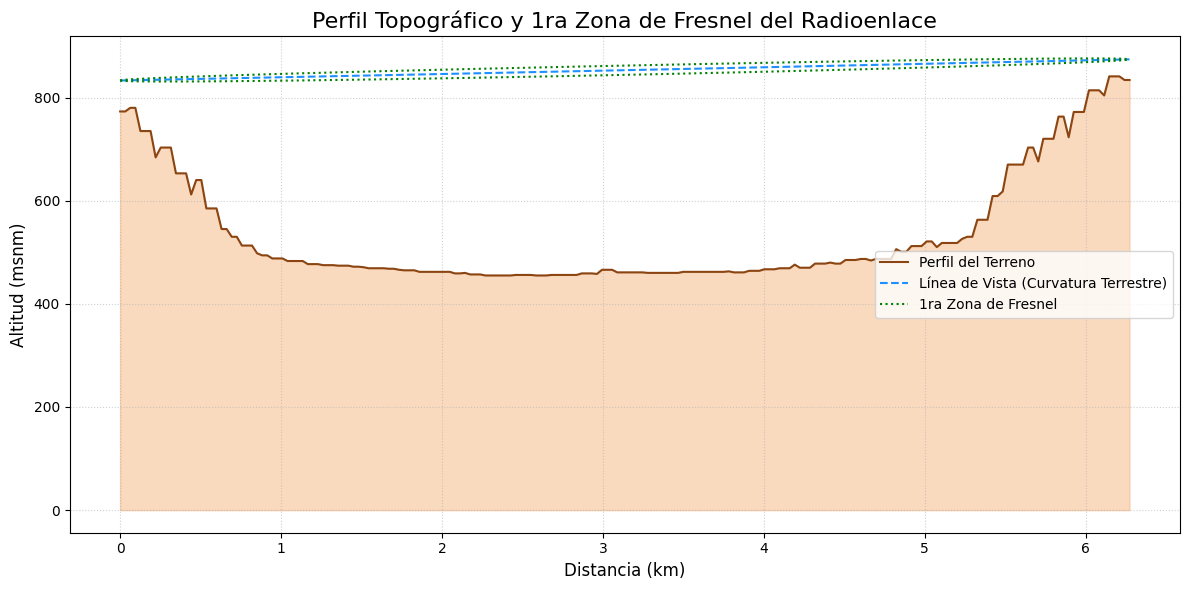

In [ ]:
# --- Bloque de Ejecución Principal ---
if 'dem_funciona' in globals() and dem_funciona:
    print("\n\n=== EJECUTANDO SIMULACIÓN DE UN ENLACE ===")
    enlace_prueba = Radioenlace(
        lat1=10.209444, lon1=-67.980556, h_ant1=60,      # Sitio A
        lat2=10.234444, lon2=-67.929167, h_ant2=40,      # Sitio B
        frecuencia=5800,
        potencia_tx=20,
        ganancia_ant1=23,
        diametro_ant2=0.6, eficiencia_ant2=0.7,
        sensibilidad_rx=-90,
        atenuacion_conector_db=0.7,
        cantidad_conectores=4,
        atenuacion_cable_o_guia_db_por_metro=0.08,
        longitud_adicional_cable_o_guia_m=10,
        factor_k=4/3
    )

    enlace_prueba.ejecutar_analisis_completo(dem_path=DEM_FILE_PATH, calc_gases=True)

    # --- MOSTRAR RESULTADOS ---
    print("\n--- RESULTADOS DEL ENLACE ---")
    print("\n[Orientación de Antenas]")
    print(f"  Distancia: {enlace_prueba.distancia:.2f} km")
    print(f"  Azimut Verdadero (A->B): {enlace_prueba.azimut_a_b_verdadero:.2f}°")
    print(f"  Azimut Magnético (A->B): {enlace_prueba.azimut_a_b_magnetico:.2f}° (Declinación: {enlace_prueba.declinacion_magnetica:.2f}°)")
    print(f"  Ángulo Elevación (A->B): {enlace_prueba.angulo_elevacion_a_b:.2f}°")

    print("\n[Presupuesto de Potencia]")
    for key, value in enlace_prueba.presupuesto.items():
        print(f"  {key}: {value:.2f}")

    print("\n[Desglose de Pérdidas (dB)]")
    for key, value in enlace_prueba.perdidas.items():
        if isinstance(value, dict):
            print(f"  {key}:")
            for sub_key, sub_value in value.items():
                print(f"    {sub_key}: {sub_value:.2f}")
        else:
            print(f"  {key}: {value:.2f}")

    # --- GENERAR GRÁFICO DEL PERFIL ---
    if enlace_prueba.perfil_topografico:
        dist = np.array([p[0] for p in enlace_prueba.perfil_topografico])
        alt = np.array([p[1] for p in enlace_prueba.perfil_topografico])
        alt_ant_a = alt[0] + enlace_prueba.sitio_a['h_ant']
        alt_ant_b = alt[-1] + enlace_prueba.sitio_b['h_ant']

        # Cálculo de la 1ra Zona de Fresnel
        f_ghz = enlace_prueba.frecuencia / 1000
        longitud_onda_m = 3e8 / (enlace_prueba.frecuencia * 1e6)
        dist_total_m = enlace_prueba.distancia * 1000

        # Se calcula el radio de la primera zona de Fresnel en cada punto
        # Se usa una máscara para evitar la división por cero en los extremos
        mask = (dist > 0) & (dist < enlace_prueba.distancia)

        radios_fresnel = np.zeros_like(dist)
        radios_fresnel[mask] = np.sqrt((dist[mask] * (enlace_prueba.distancia - dist[mask])) / (f_ghz * enlace_prueba.distancia)) * 17.32

        # Se calcula la altura de la línea de vista corregida por la curvatura terrestre
        dist_m = dist * 1000
        h_los_recta = alt_ant_a + (alt_ant_b - alt_ant_a) * (dist_m / dist_total_m)
        correccion_curvatura = (dist_m * (dist_total_m - dist_m)) / (2 * 6371000 * enlace_prueba.k)
        h_los_curva = h_los_recta - correccion_curvatura

        # Se definen las envolventes superior e inferior de la Zona de Fresnel
        elipsoide_sup = h_los_curva + radios_fresnel
        elipsoide_inf = h_los_curva - radios_fresnel

        # Gráfico
        plt.figure(figsize=(12, 6))
        plt.plot(dist, alt, color='saddlebrown', label='Perfil del Terreno')
        plt.fill_between(dist, alt, color='sandybrown', alpha=0.4)

        # Se traza la línea de vista corregida
        plt.plot(dist, h_los_curva, color='dodgerblue', linestyle='--', label='Línea de Vista (Curvatura Terrestre)')

        # Se traza la primera zona de Fresnel
        plt.plot(dist, elipsoide_sup, color='green', linestyle=':', label='1ra Zona de Fresnel')
        plt.plot(dist, elipsoide_inf, color='green', linestyle=':')

        plt.title('Perfil Topográfico y 1ra Zona de Fresnel del Radioenlace', fontsize=16)
        plt.xlabel('Distancia (km)', fontsize=12)
        plt.ylabel('Altitud (msnm)', fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("\nNo se pudo ejecutar la simulación porque el DEM no está funcionando correctamente.")

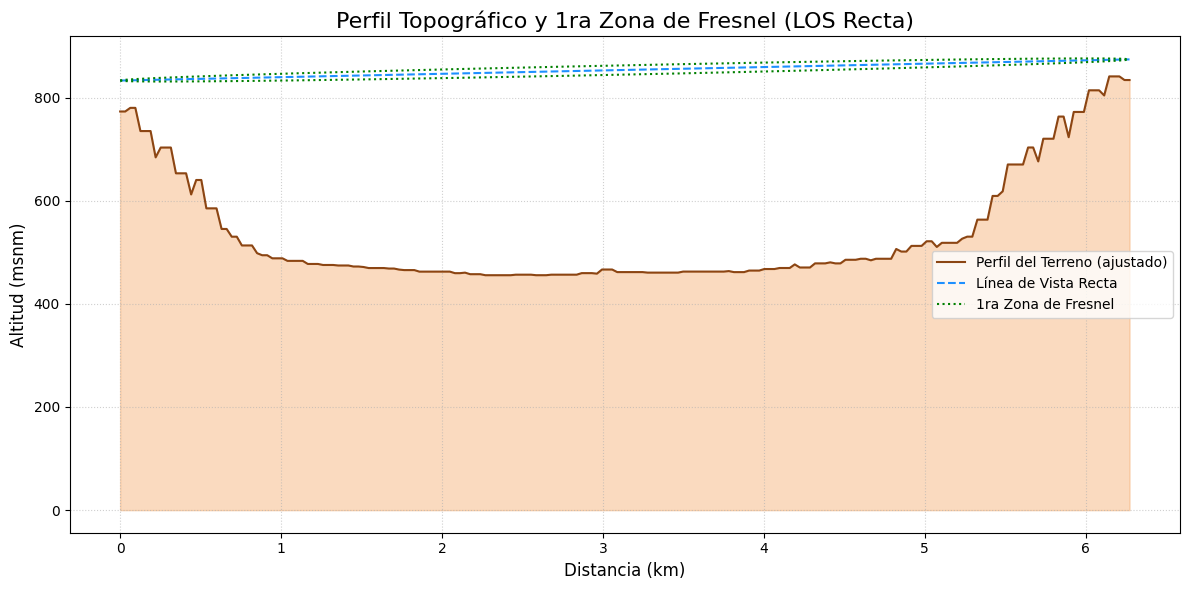

In [ ]:
# --- GENERAR GRÁFICO DEL PERFIL ---
if enlace_prueba.perfil_topografico:
    dist = np.array([p[0] for p in enlace_prueba.perfil_topografico])
    alt_terreno_original = np.array([p[1] for p in enlace_prueba.perfil_topografico])

    # Alturas de las antenas sobre el nivel del mar
    alt_ant_a = alt_terreno_original[0] + enlace_prueba.sitio_a['h_ant']
    alt_ant_b = alt_terreno_original[-1] + enlace_prueba.sitio_b['h_ant']

    # Se calculan las alturas del terreno ajustadas por la curvatura terrestre
    dist_m = dist * 1000
    dist_total_m = enlace_prueba.distancia * 1000
    R_efectiva_m = 6371000 * enlace_prueba.k

    correccion_curvatura = (dist_m * (dist_total_m - dist_m)) / (2 * R_efectiva_m)
    alt_terreno_ajustada = alt_terreno_original + correccion_curvatura

    # Se calcula la 1ra Zona de Fresnel
    f_ghz = enlace_prueba.frecuencia / 1000
    radios_fresnel = np.sqrt((dist * (enlace_prueba.distancia - dist)) / (f_ghz * enlace_prueba.distancia)) * 17.32

    # Se define la línea de vista como una recta simple
    h_los_recta = alt_ant_a + (alt_ant_b - alt_ant_a) * (dist / enlace_prueba.distancia)

    # Se definen las envolventes superior e inferior de la Zona de Fresnel
    elipsoide_sup = h_los_recta + radios_fresnel
    elipsoide_inf = h_los_recta - radios_fresnel

    # Gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(dist, alt_terreno_ajustada, color='saddlebrown', label='Perfil del Terreno (ajustado)')
    plt.fill_between(dist, alt_terreno_ajustada, color='sandybrown', alpha=0.4)

    # Se traza la línea de vista como una recta
    plt.plot(dist, h_los_recta, color='dodgerblue', linestyle='--', label='Línea de Vista Recta')

    # Se traza la primera zona de Fresnel como un elipsoide
    plt.plot(dist, elipsoide_sup, color='green', linestyle=':', label='1ra Zona de Fresnel')
    plt.plot(dist, elipsoide_inf, color='green', linestyle=':')

    plt.title('Perfil Topográfico y 1ra Zona de Fresnel (LOS Recta)', fontsize=16)
    plt.xlabel('Distancia (km)', fontsize=12)
    plt.ylabel('Altitud (msnm)', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()



=== EJECUTANDO SIMULACIÓN DE UN ENLACE ===
Ganancia de antena RX calculada (D=0.6m, F=5800MHz, Efic.=0.7): 29.68 dBi
Pérdidas por 4 conectores: 2.80 dB
Pérdidas por cable/guía de onda (90.0m): 7.20 dB
Pérdidas fijas totales calculadas: 10.00 dB

--- INICIANDO ANÁLISIS COMPLETO DEL RADIOENLACE ---
Distancia: 696.96 km
Azimut Verdadero A->B: 90.12°
Declinación Magnética en Sitio A: -12.64°
Azimut Magnético A->B: 102.76°
Azimut Magnético B->A: 282.76°
Perfil topográfico extraído.
Ángulo de Elevación de A a B: -2.35°
Ángulo de Elevación de B a A: -2.35°
Verificación de LOS: OBSTRUIDO (obstrucción significativa)
Despeje de la 1ra Zona de Fresnel: 0.0%
Pérdida por Difracción calculada: 50.41 dB

--- Recalculando Azimut con Altitud Precisa ---
Distancia: 696.96 km
Azimut Verdadero A->B: 90.12°
Declinación Magnética en Sitio A: -12.64°
Azimut Magnético A->B: 102.76°
Azimut Magnético B->A: 282.76°
--- ANÁLISIS FINALIZADO ---

--- RESULTADOS DEL ENLACE ---

[Orientación de Antenas]
  Distancia

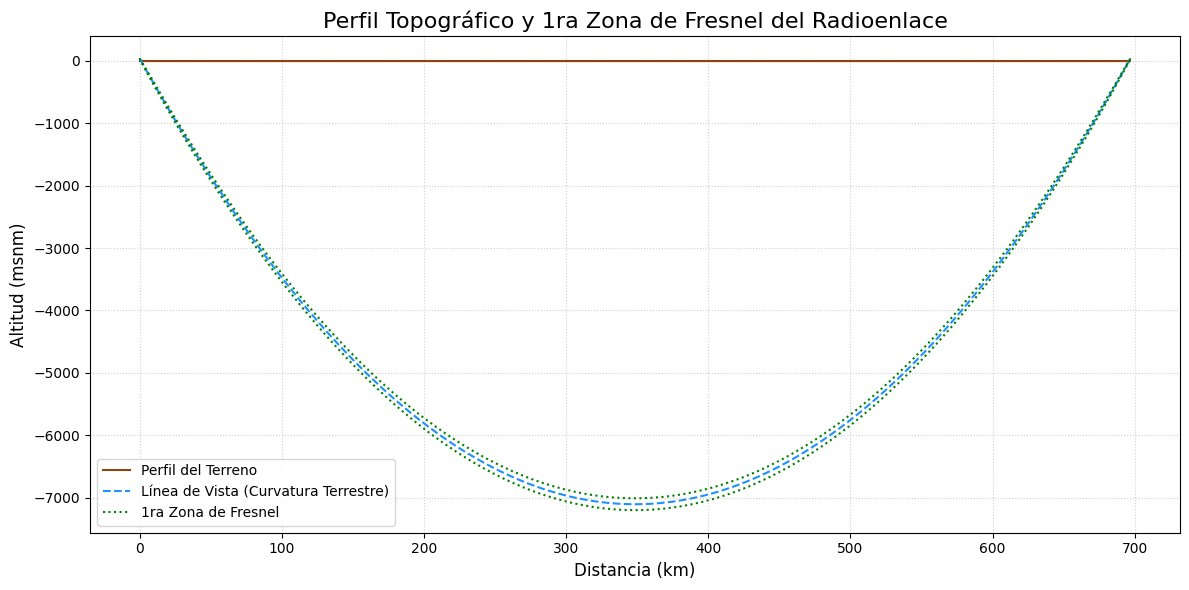

In [ ]:
# --- Bloque de Ejecución Principal ---
if 'dem_funciona' in globals() and dem_funciona:
    print("\n\n=== EJECUTANDO SIMULACIÓN DE UN ENLACE ===")
    enlace_prueba = Radioenlace(
        lat1=11.374031, lon1=-68.066220, h_ant1=40,      # Sitio A
        lat2=11.292015, lon2=-61.674109, h_ant2=40,      # Sitio B
        frecuencia=5800,
        potencia_tx=20,
        ganancia_ant1=23,
        diametro_ant2=0.6, eficiencia_ant2=0.7,
        sensibilidad_rx=-90,
        atenuacion_conector_db=0.7,
        cantidad_conectores=4,
        atenuacion_cable_o_guia_db_por_metro=0.08,
        longitud_adicional_cable_o_guia_m=10,
        factor_k=4/3
    )

    enlace_prueba.ejecutar_analisis_completo(dem_path=DEM_FILE_PATH, calc_gases=True)

    # --- MOSTRAR RESULTADOS ---
    print("\n--- RESULTADOS DEL ENLACE ---")
    print("\n[Orientación de Antenas]")
    print(f"  Distancia: {enlace_prueba.distancia:.2f} km")
    print(f"  Azimut Verdadero (A->B): {enlace_prueba.azimut_a_b_verdadero:.2f}°")
    print(f"  Azimut Magnético (A->B): {enlace_prueba.azimut_a_b_magnetico:.2f}° (Declinación: {enlace_prueba.declinacion_magnetica:.2f}°)")
    print(f"  Ángulo Elevación (A->B): {enlace_prueba.angulo_elevacion_a_b:.2f}°")

    print("\n[Presupuesto de Potencia]")
    for key, value in enlace_prueba.presupuesto.items():
        print(f"  {key}: {value:.2f}")

    print("\n[Desglose de Pérdidas (dB)]")
    for key, value in enlace_prueba.perdidas.items():
        if isinstance(value, dict):
            print(f"  {key}:")
            for sub_key, sub_value in value.items():
                print(f"    {sub_key}: {sub_value:.2f}")
        else:
            print(f"  {key}: {value:.2f}")

    # --- GENERAR GRÁFICO DEL PERFIL ---
    if enlace_prueba.perfil_topografico:
        dist = np.array([p[0] for p in enlace_prueba.perfil_topografico])
        alt = np.array([p[1] for p in enlace_prueba.perfil_topografico])
        alt_ant_a = alt[0] + enlace_prueba.sitio_a['h_ant']
        alt_ant_b = alt[-1] + enlace_prueba.sitio_b['h_ant']

        # Cálculo de la 1ra Zona de Fresnel
        f_ghz = enlace_prueba.frecuencia / 1000
        longitud_onda_m = 3e8 / (enlace_prueba.frecuencia * 1e6)
        dist_total_m = enlace_prueba.distancia * 1000

        # Se calcula el radio de la primera zona de Fresnel en cada punto
        # Se usa una máscara para evitar la división por cero en los extremos
        mask = (dist > 0) & (dist < enlace_prueba.distancia)

        radios_fresnel = np.zeros_like(dist)
        radios_fresnel[mask] = np.sqrt((dist[mask] * (enlace_prueba.distancia - dist[mask])) / (f_ghz * enlace_prueba.distancia)) * 17.32

        # Se calcula la altura de la línea de vista corregida por la curvatura terrestre
        dist_m = dist * 1000
        h_los_recta = alt_ant_a + (alt_ant_b - alt_ant_a) * (dist_m / dist_total_m)
        correccion_curvatura = (dist_m * (dist_total_m - dist_m)) / (2 * 6371000 * enlace_prueba.k)
        h_los_curva = h_los_recta - correccion_curvatura

        # Se definen las envolventes superior e inferior de la Zona de Fresnel
        elipsoide_sup = h_los_curva + radios_fresnel
        elipsoide_inf = h_los_curva - radios_fresnel

        # Gráfico
        plt.figure(figsize=(12, 6))
        plt.plot(dist, alt, color='saddlebrown', label='Perfil del Terreno')
        plt.fill_between(dist, alt, color='sandybrown', alpha=0.4)

        # Se traza la línea de vista corregida
        plt.plot(dist, h_los_curva, color='dodgerblue', linestyle='--', label='Línea de Vista (Curvatura Terrestre)')

        # Se traza la primera zona de Fresnel
        plt.plot(dist, elipsoide_sup, color='green', linestyle=':', label='1ra Zona de Fresnel')
        plt.plot(dist, elipsoide_inf, color='green', linestyle=':')

        plt.title('Perfil Topográfico y 1ra Zona de Fresnel del Radioenlace', fontsize=16)
        plt.xlabel('Distancia (km)', fontsize=12)
        plt.ylabel('Altitud (msnm)', fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("\nNo se pudo ejecutar la simulación porque el DEM no está funcionando correctamente.")

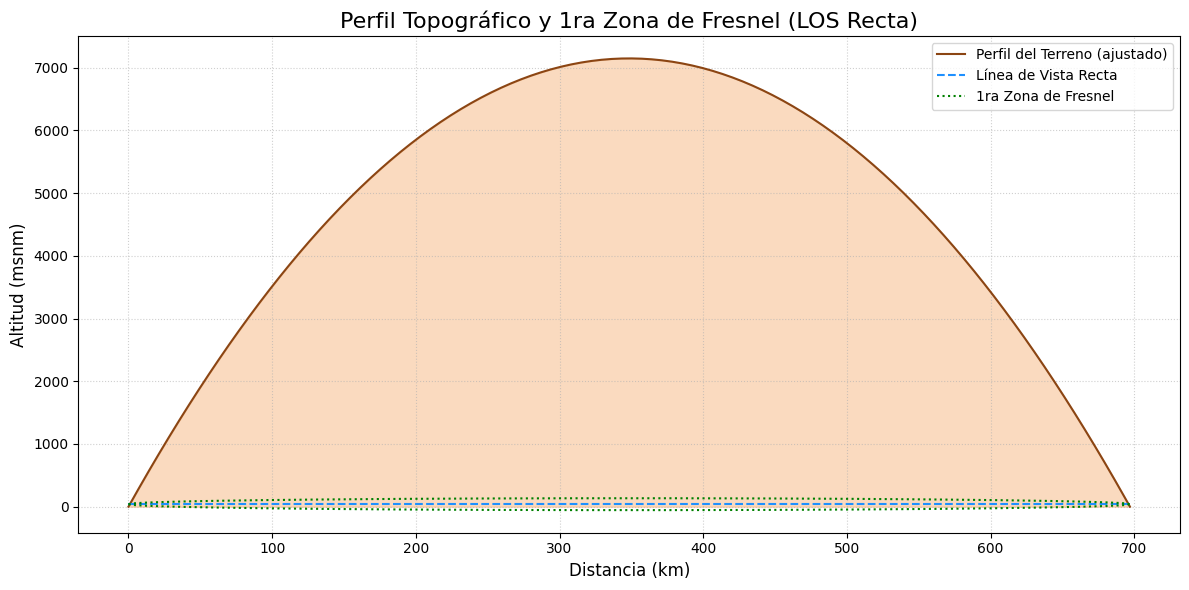

In [ ]:
# --- GENERAR GRÁFICO DEL PERFIL ---
if enlace_prueba.perfil_topografico:
    dist = np.array([p[0] for p in enlace_prueba.perfil_topografico])
    alt_terreno_original = np.array([p[1] for p in enlace_prueba.perfil_topografico])

    # Alturas de las antenas sobre el nivel del mar
    alt_ant_a = alt_terreno_original[0] + enlace_prueba.sitio_a['h_ant']
    alt_ant_b = alt_terreno_original[-1] + enlace_prueba.sitio_b['h_ant']

    # Se calculan las alturas del terreno ajustadas por la curvatura terrestre
    dist_m = dist * 1000
    dist_total_m = enlace_prueba.distancia * 1000
    R_efectiva_m = 6371000 * enlace_prueba.k

    correccion_curvatura = (dist_m * (dist_total_m - dist_m)) / (2 * R_efectiva_m)
    alt_terreno_ajustada = alt_terreno_original + correccion_curvatura

    # Se calcula la 1ra Zona de Fresnel
    f_ghz = enlace_prueba.frecuencia / 1000
    radios_fresnel = np.sqrt((dist * (enlace_prueba.distancia - dist)) / (f_ghz * enlace_prueba.distancia)) * 17.32

    # Se define la línea de vista como una recta simple
    h_los_recta = alt_ant_a + (alt_ant_b - alt_ant_a) * (dist / enlace_prueba.distancia)

    # Se definen las envolventes superior e inferior de la Zona de Fresnel
    elipsoide_sup = h_los_recta + radios_fresnel
    elipsoide_inf = h_los_recta - radios_fresnel

    # Gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(dist, alt_terreno_ajustada, color='saddlebrown', label='Perfil del Terreno (ajustado)')
    plt.fill_between(dist, alt_terreno_ajustada, color='sandybrown', alpha=0.4)

    # Se traza la línea de vista como una recta
    plt.plot(dist, h_los_recta, color='dodgerblue', linestyle='--', label='Línea de Vista Recta')

    # Se traza la primera zona de Fresnel como un elipsoide
    plt.plot(dist, elipsoide_sup, color='green', linestyle=':', label='1ra Zona de Fresnel')
    plt.plot(dist, elipsoide_inf, color='green', linestyle=':')

    plt.title('Perfil Topográfico y 1ra Zona de Fresnel (LOS Recta)', fontsize=16)
    plt.xlabel('Distancia (km)', fontsize=12)
    plt.ylabel('Altitud (msnm)', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()